In [1]:
#!pip install torch torchvision

import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib
from matplotlib import pyplot as plt


np.random.seed(1234)
torch.manual_seed(1234)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Found device : {device}")

/home/sudarsun/1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found device : cuda


In [2]:
# When we load the data, they exist as as PIL images, convert to tensors, cell values are in [0, 1] so we don't need to normalize them.
transform = transforms.Compose([transforms.ToTensor()])

# load dataset
data_folder = "./fashionMNIST"
train_data = torchvision.datasets.FashionMNIST(data_folder, train=True, download=True, transform=transform)
test_data  = torchvision.datasets.FashionMNIST(data_folder, train=False, download=True, transform=transform)

# split training data into training and validation sets
train_data, valid_data = torch.utils.data.random_split(train_data, [50000,10000]) # 50k train, 10k validation

batch_size =1000
# data iterators
train_set  = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_set  = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)
test_set   = torch.utils.data.DataLoader(test_data,  shuffle=False, batch_size=batch_size)

In [3]:
# define the model

class EncoderDeep(nn.Module):
    def __init__(self, n_components):
        super(EncoderDeep, self).__init__()
        self.fc1 = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4_mean = nn.Linear(250, n_components)
        self.fc4_std = nn.Linear(250, n_components)

    def forward(self, x):
        x = x.view(-1, 1, self.fc1.in_features)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = self.fc4_mean(x)
        std = self.fc4_std(x)
        return mu, std


class DecoderDeep(nn.Module):
    def __init__(self, n_components):
        super(DecoderDeep, self).__init__()
        self.fc1 = nn.Linear(n_components, 250)
        self.fc2 = nn.Linear(250, 500)
        self.fc3 = nn.Linear(500, 1000)
        self.fc4 = nn.Linear(1000, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x)) # self.fc4(x)#
        x = x.view(-1, 1, 28, 28)
        return x


def reparameterize(mu, std):
    """
    Take in mean and log(standard deviation) of a Normal distribution,
    and output a n_samples from the corresponding gaussian.
    """
    z_samples = torch.randn_like(mu)
    rep_samples = std*z_samples + mu
    return rep_samples

In [4]:
# training stuff
n_components = 2 # 2 dimensional latent space
encoder = EncoderDeep(n_components=n_components)
decoder = DecoderDeep(n_components=n_components)

encoder = encoder.cuda()
decoder = decoder.cuda()

params = list(encoder.parameters()) + list(decoder.parameters())

optimizer = torch.optim.Adam(params=params, lr=1e-3)

criterion = nn.BCELoss(reduction='sum')


In [5]:
n_epochs = 30

encoder.train()
decoder.train()

kl_losses    = []
recon_losses = []
elbo         = []
for epoch in range(n_epochs):
    kl_  = []
    rec_ = []
    elbo_= []
    for data, label in train_set:
        data = data.cuda()
        optimizer.zero_grad()

        z_means, z_stds = encoder(data)
        z_stds = torch.exp(z_stds)

        z = reparameterize(z_means, z_stds)
        x = decoder(z)
        loss_reconstruction = criterion(x, data)/batch_size

        # https://ai.stackexchange.com/questions/26366/how-is-this-pytorch-expression-equivalent-to-the-kl-divergence
        loss_kl = -torch.mean(0.5*torch.sum(1 - torch.pow(z_stds,2) - torch.pow(z_means,2) + torch.log(torch.pow(z_stds,2)), dim=-1))

        loss = loss_reconstruction + loss_kl

        loss.backward()
        optimizer.step()

        kl_.append(loss_kl.item())
        rec_.append(loss_reconstruction.item())
        elbo_.append(loss.item())

    kl_losses.append(np.mean(kl_))
    recon_losses.append(np.mean(rec_))
    elbo.append(np.mean(elbo_))
    print("Epoch {:3d}  Reconstruction Loss {:7>.7f} KL loss {:7>.7f}, ELBO {:7>.7f}".format(epoch, recon_losses[-1], kl_losses[-1], elbo[-1]))

Epoch   0  Reconstruction Loss 376.7808264 KL loss 2.5611500, ELBO 379.3419739
Epoch   1  Reconstruction Loss 285.8991840 KL loss 6.9498208, ELBO 292.8490039
Epoch   2  Reconstruction Loss 272.2447504 KL loss 6.7074826, ELBO 278.9522321
Epoch   3  Reconstruction Loss 267.3145996 KL loss 6.3610450, ELBO 273.6756445
Epoch   4  Reconstruction Loss 263.9523923 KL loss 6.2572378, ELBO 270.2096277
Epoch   5  Reconstruction Loss 261.4635638 KL loss 6.2389823, ELBO 267.7025476
Epoch   6  Reconstruction Loss 260.0069852 KL loss 6.2211269, ELBO 266.2281110
Epoch   7  Reconstruction Loss 258.7372778 KL loss 6.2021975, ELBO 264.9394745
Epoch   8  Reconstruction Loss 257.7386685 KL loss 6.2009452, ELBO 263.9396094
Epoch   9  Reconstruction Loss 256.9268002 KL loss 6.2062863, ELBO 263.1330865
Epoch  10  Reconstruction Loss 256.3869620 KL loss 6.2062621, ELBO 262.5932245
Epoch  11  Reconstruction Loss 256.0016827 KL loss 6.1954917, ELBO 262.1971753
Epoch  12  Reconstruction Loss 254.9994336 KL loss 6

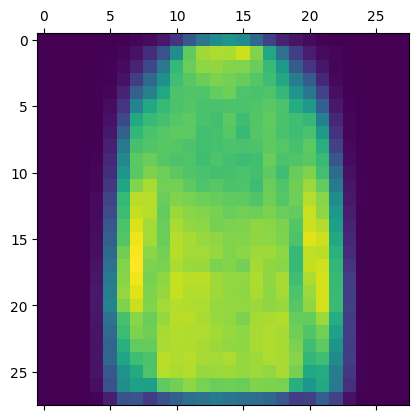

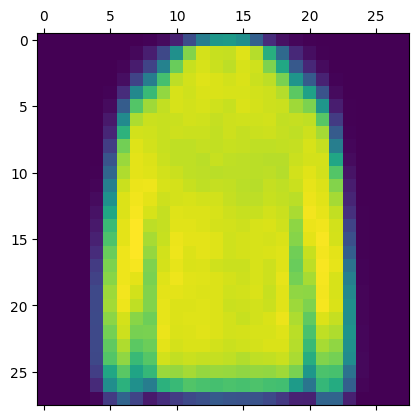

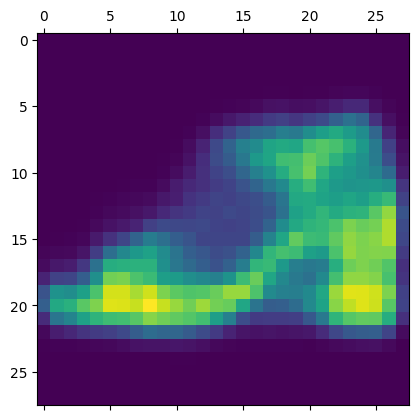

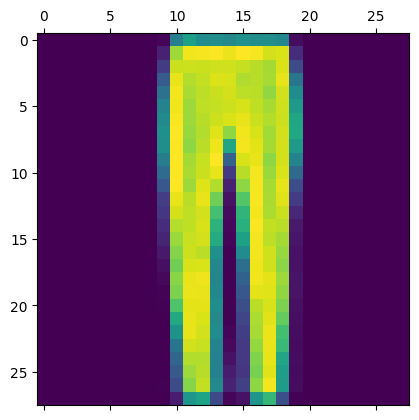

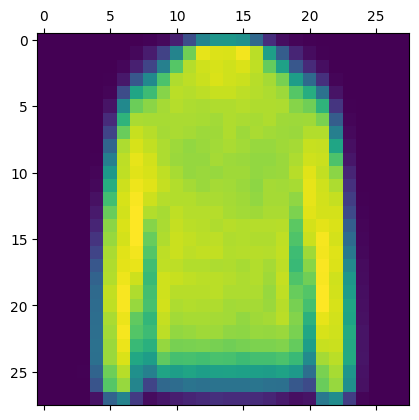

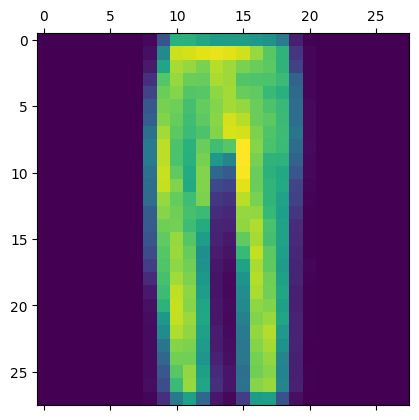

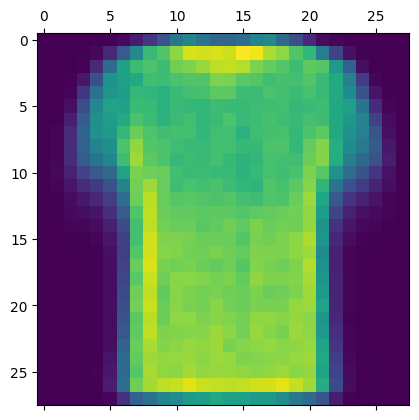

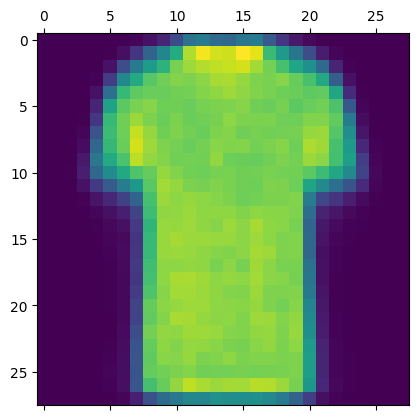

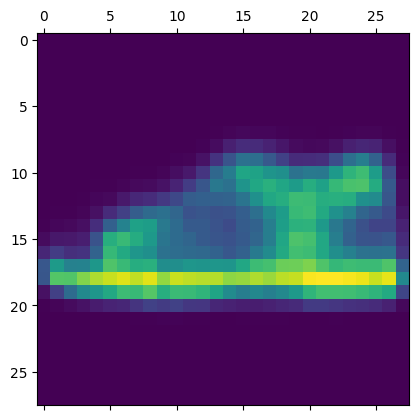

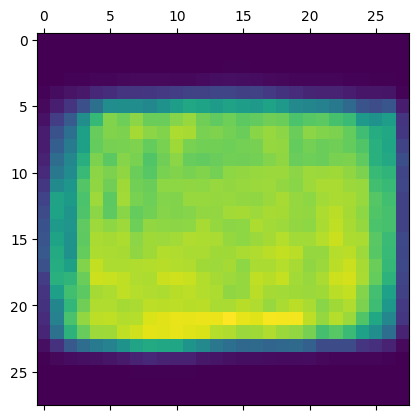

In [6]:
for i in range(10):
    plt.matshow(x[i].detach().cpu().numpy().reshape(28,28))

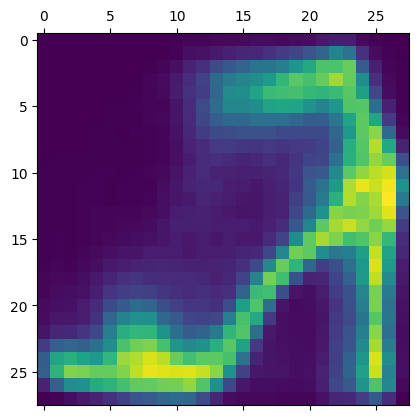

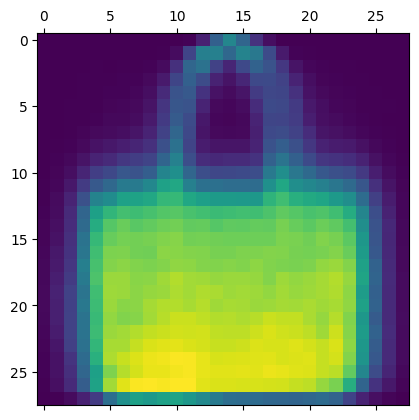

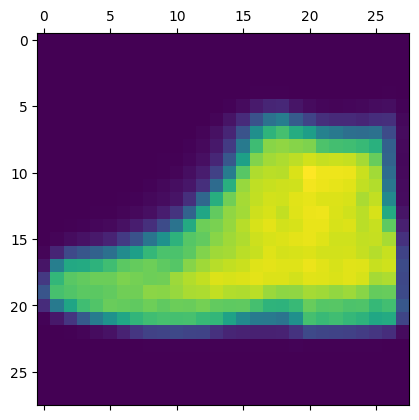

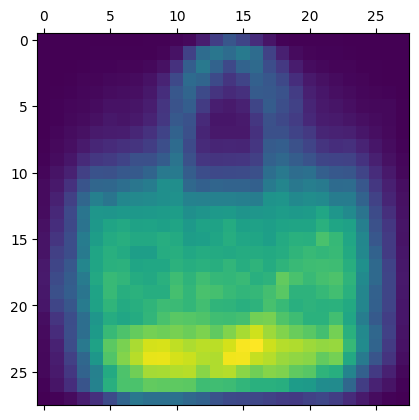

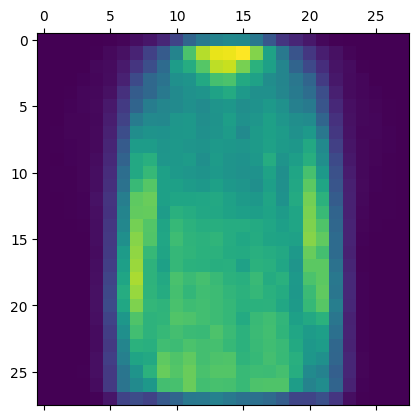

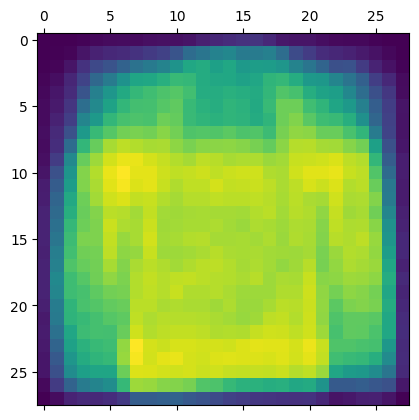

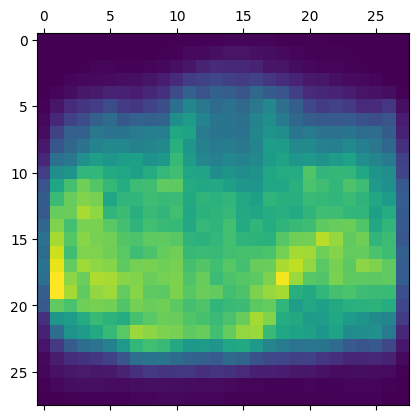

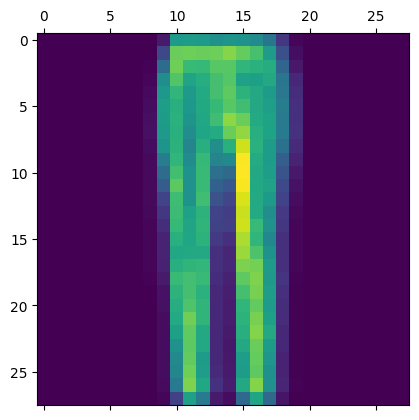

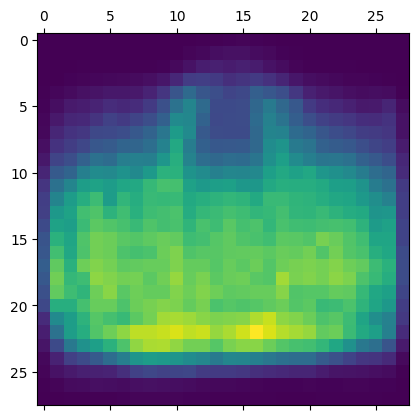

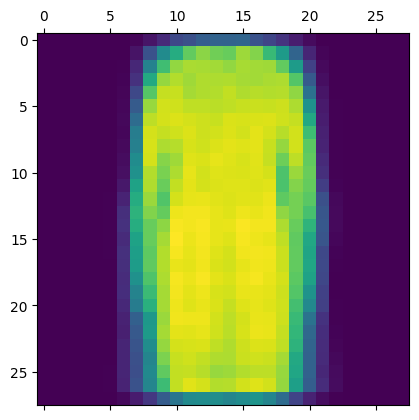

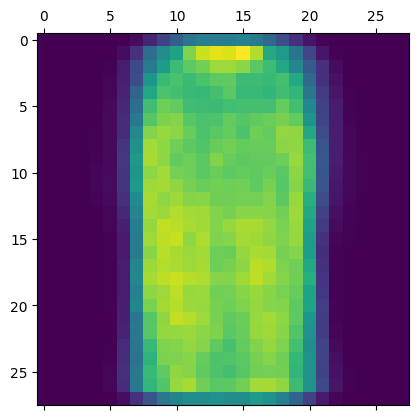

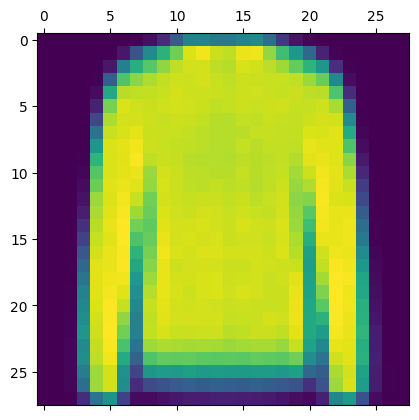

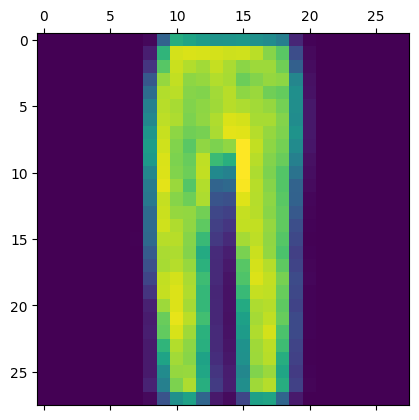

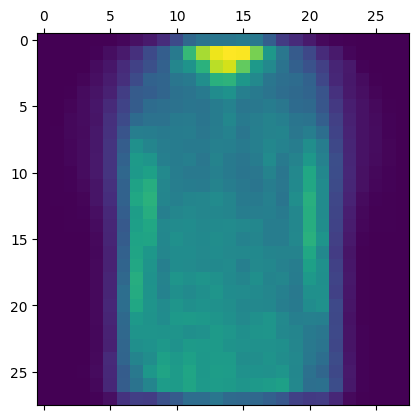

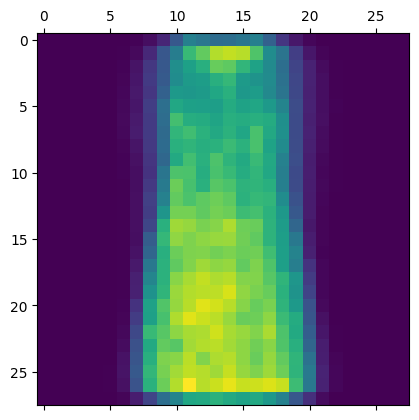

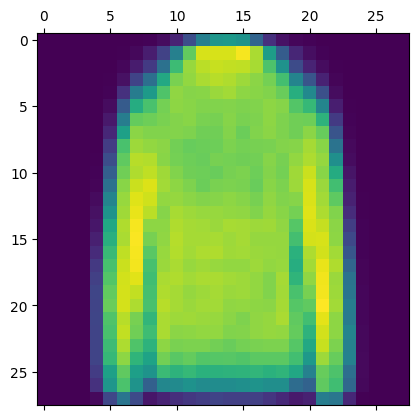

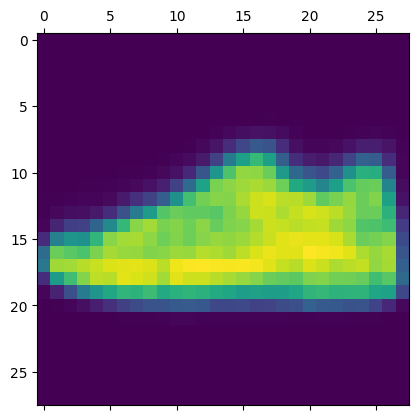

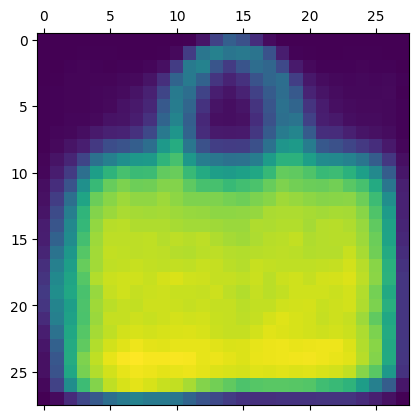

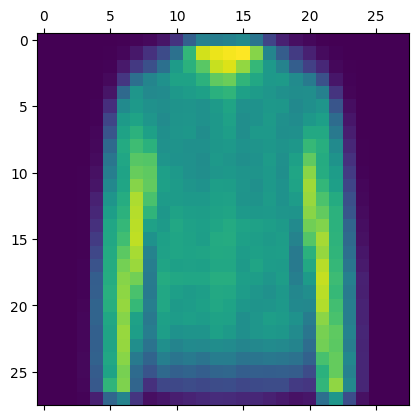

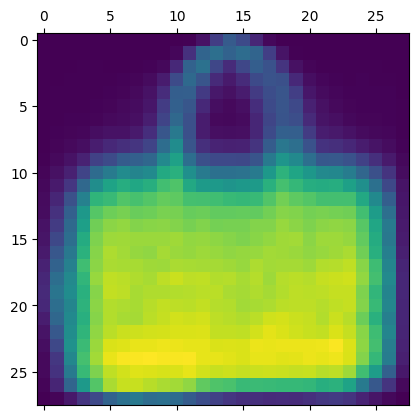

In [7]:
z_new = torch.randn_like(z_means)
x_new = decoder(z_new)
for i in range(20):
    plt.matshow(x_new[i].detach().cpu().numpy().reshape(28,28))


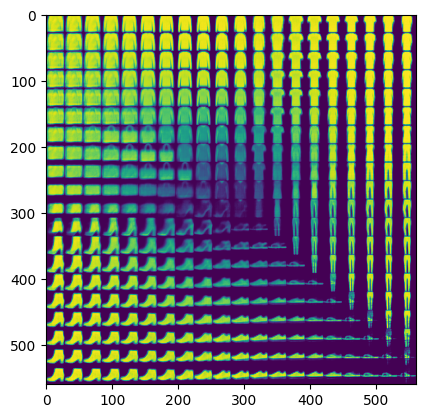

In [12]:
x = np.linspace(-3,3,20)
y = np.linspace(-3,3,20)
X,Y = np.meshgrid(x,y)
z_grid = np.hstack((X.reshape(400,1), Y.reshape(400,1)))
z_grid = torch.from_numpy(z_grid).float()
z_grid = z_grid

new_decoder = decoder.cpu()
x_new = new_decoder(z_grid)

def convert_to_oneimage(x_new):
    """
    x_new is assumed to be n_row**2, 1, width, height
    concretely, (100, 1, 28, 28) so 100 images of 28,28
    """
    n_rows = int(np.sqrt(x_new.shape[0]))
    w,h = x_new.shape[2], x_new.shape[3]
    new_img = np.zeros((n_rows*w, n_rows*h))

    for row in range(n_rows):
        for col in range(n_rows):
            new_img[row*w:row*w+w,col*h:col*h+h] = x_new[row*n_rows+col].reshape(w,h)
    plt.imshow(new_img)

convert_to_oneimage(x_new.detach().numpy())